<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, msa_flagging step for mos prism

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and msa_flagging validation tests](#pipeline_ID): [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing the NIRSpec Pipeline Testing Tool.

* os for filepaths
* subprocess for installing NPTT and moving output files
* astropy.io for opening fits files
* jwst.msaflagopen.msaflagopen_step is the pipeline step being tested

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install NPTT (https://github.com/spacetelescope/nirspec_pipe_testing_tool). 

If the installation is successful, you will be able to import NPTT.

[Top of Page](#title_ID)

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.8.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The test is a comparison of the result of our implementation of the MSA Failed Open Flagging step algorithm versus the pipeline's implementation.

The overlap between the pixels flagged as being affected by failed open shutters are compared in regions large enough in the spectral direction to account for the non-repeatable motion of the grating wheel (a few pixels).

For the test to be considered PASSED, the overlap between the results of the two methods should be greater than or equal to msa_flagging_threshold percent for all failed open shutters affecting more than 100 pixels.

The code for these Multi Object Spectroscopy (MOS) and Integral Field Unit (IFU) tests can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/msa_flagging_testing.py. This pipeline step and the associated pytests are skipped if data is Fixed Slits (FS) or Bright Object Time Series (BOTS).

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/msaflagopen/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/msaflagopen


### Results

If the test **PASSED** this means that all slitlets or slices individually passed the test. However, if ony one individual slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+MSA+Failed+Open+Flagging


### Defining Terms
Acronymns used in this notebook:

pipeline: calibration pipeline

cal_detector1: calibration pipeline Stage 1, detector processing

spec2: calibration pipeline spectroscopic Stage 2, spectroscopic processing

NPTT: NIRSpec Pipeline Testing Tool


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and msa_flagging validation tests

The pipeline can be run from the command line in two variants: full or per step.

To run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

where jwtest_rate.fits is the output of cal_detector1.

To only run the msa_flagging step, use the command:

$ strun jwst.msaflagopen.msaflagopen_step jwtest_assign_wcs.fits

where jwtest_assign_wcs.fits is the output of the previous step, assign_wcs.

NIRSpec TA data will be run through the calwebb_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following command:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.msaflagopen.msaflagopen_step import msaflagopen_step
 
$\gt$ msaflagopen_step.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used for testing:
- MOS_PRISM_CLEAR


[Top of Page](#title_ID)

In [5]:
testing_data = {                
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' }
               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/mos_prism_nrs1_uncal.fits


2022-12-03 23:44:52,366 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-12-03 23:44:52,397 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-03 23:44:52,399 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-03 23:44:52,400 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-03 23:44:52,401 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-03 23:44:52,402 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-03 23:44:52,403 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-03 23:44:52,404 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-03 23:44:52,405 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-03 23:44:52,406 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-03 23:44:52,407 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-03 23:44:52,408 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-03 23:44:52,410 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-03 23:44:52,411 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-03 23:44:52,412 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-03 23:44:52,413 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-03 23:44:52,414 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-03 23:44:52,416 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-03 23:44:52,596 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/mos_prism_nrs1_uncal.fits',).


2022-12-03 23:44:52,606 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-12-03 23:44:52,813 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_prism_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-03 23:44:52,848 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits'.


2022-12-03 23:44:52,852 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-12-03 23:44:52,856 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits'.


2022-12-03 23:44:52,858 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits'.


2022-12-03 23:44:52,861 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-03 23:44:52,862 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits'.


2022-12-03 23:44:52,866 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits'.


2022-12-03 23:44:52,869 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-12-03 23:44:52,870 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-12-03 23:44:52,870 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits'.


2022-12-03 23:44:52,874 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits'.


2022-12-03 23:44:52,880 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-03 23:44:52,880 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-03 23:44:52,881 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-03 23:44:53,311 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:44:53,313 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:44:53,469 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-12-03 23:44:53,470 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-03 23:44:53,472 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-03 23:44:53,614 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:44:53,616 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:44:53,648 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits


2022-12-03 23:44:54,864 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-03 23:44:55,011 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:44:55,012 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'n_pix_grow_sat': 1}


2022-12-03 23:44:55,035 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0020.fits


2022-12-03 23:44:57,317 - stpipe.Detector1Pipeline.saturation - INFO - Detected 49730 saturated pixels


2022-12-03 23:44:57,351 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-03 23:44:57,379 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-03 23:44:57,546 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:44:57,548 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:44:57,549 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-03 23:44:57,552 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-03 23:44:57,705 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:44:57,706 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:44:57,733 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0113.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-12-03 23:45:03,508 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-12-03 23:45:03,656 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:45:03,658 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-03 23:45:03,683 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0022.fits


2022-12-03 23:45:07,185 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-12-03 23:45:21,830 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-03 23:45:22,192 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:45:22,194 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:45:22,221 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0018.fits


2022-12-03 23:45:30,800 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-03 23:45:30,986 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:45:30,988 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'dark_output': None}


2022-12-03 23:45:31,066 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0086.fits


2022-12-03 23:46:16,629 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2022-12-03 23:46:16,630 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-12-03 23:46:17,245 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-03 23:46:17,481 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:17,483 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-03 23:46:17,523 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-03 23:46:17,577 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-12-03 23:46:18,742 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-12-03 23:46:20,574 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-03 23:46:20,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-12-03 23:46:22,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-12-03 23:46:22,658 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.08269 sec


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:302: RuntimeWarning: invalid value encountered in divide
  data /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:303: RuntimeWarning: invalid value encountered in divide
  err /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:304: RuntimeWarning: invalid value encountered in divide
  readnoise_2d /= gain_2d
2022-12-03 23:46:22,725 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 5.201375


2022-12-03 23:46:22,731 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-03 23:46:22,935 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:22,937 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-03 23:46:23,054 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-12-03 23:46:23,055 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-12-03 23:46:23,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-03 23:46:23,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-12-03 23:46:37,881 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2022-12-03 23:46:37,882 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-12-03 23:46:38,094 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-03 23:46:38,310 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:38,312 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:46:38,394 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 23:46:38,395 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 23:46:38,400 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 23:46:38,580 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:38,581 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:46:38,658 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 23:46:38,659 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 23:46:38,664 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 23:46:38,665 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-03 23:46:38,665 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 23:46:38,666 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-03 23:46:38,676 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 23:46:38,841 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:38,843 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Using MSA shutter config:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/V0030006000104_msa.fits


2022-12-03 23:46:38,995 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-12-03 23:46:39,042 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:46:39,043 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:46:39,044 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:46:39,045 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:46:39,336 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4]


2022-12-03 23:46:39,337 - stpipe.AssignWcsStep - INFO - Computing WCS for 2 open slitlets


2022-12-03 23:46:39,399 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:46:39,400 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:46:39,400 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:46:39,402 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:46:39,417 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-12-03 23:46:39,578 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1


2022-12-03 23:46:39,578 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-12-03 23:46:39,579 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3


2022-12-03 23:46:39,588 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 4


2022-12-03 23:46:39,598 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-12-03 23:46:39,777 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/V0030006000104_msa.fits'}


2022-12-03 23:46:39,977 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-03 23:46:39,992 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 23:46:39,992 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-12-03 23:46:40,002 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-12-03 23:46:40,205 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:40,206 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-12-03 23:46:40,226 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-12-03 23:46:40,228 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-12-03 23:46:40,357 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:46:40,358 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:46:40,359 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:46:40,360 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:46:40,375 - stpipe.MSAFlagOpenStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-12-03 23:46:40,539 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-12-03 23:46:40,581 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-12-03 23:46:40,605 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-12-03 23:46:40,679 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-12-03 23:46:40,704 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2588.086193887466.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2332.7637849323596.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2734.225436305883.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2098.587600763162.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2088.836558573466.
  warnings.warn(f"Invalid interval: upper bound {upper} "


2022-12-03 23:46:52,586 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 23:46:52,587 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


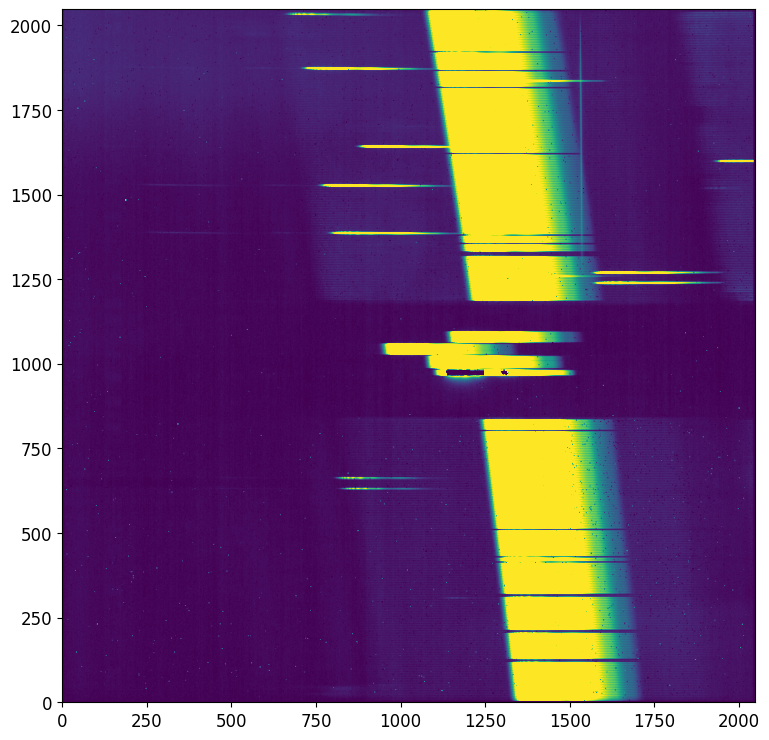

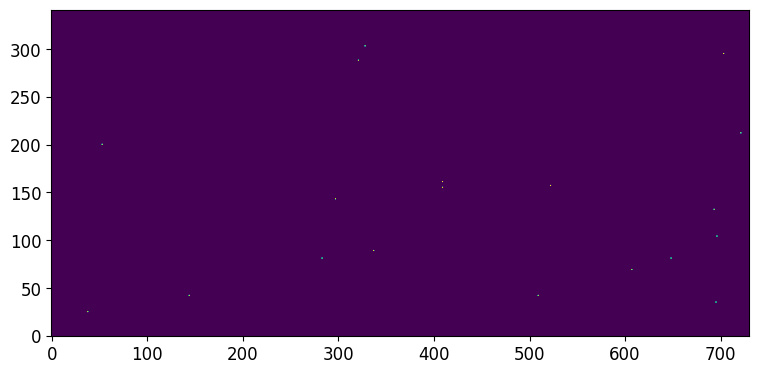

2022-12-03 23:46:53,436 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 23:46:53,448 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 23:46:53,843 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).


2022-12-03 23:46:53,845 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.45, 'slit_y_high': 0.45}


2022-12-03 23:46:54,000 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-12-03 23:46:54,062 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:46:54,063 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:46:54,064 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:46:54,066 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:46:54,297 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:46:54,337 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:46:54,491 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:46:54,531 - stpipe.AssignWcsStep - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:46:54,569 - stpipe.AssignWcsStep - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:46:54,980 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2022-12-03 23:46:54,981 - stpipe.AssignWcsStep - INFO - Computing WCS for 14 open slitlets


2022-12-03 23:46:55,022 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:46:55,023 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:46:55,024 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:46:55,026 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:46:55,040 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]


2022-12-03 23:46:55,195 - stpipe.AssignWcsStep - INFO - There are 3 open slits in quadrant 1


2022-12-03 23:46:55,220 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2


2022-12-03 23:46:55,221 - stpipe.AssignWcsStep - INFO - There are 9 open slits in quadrant 3


2022-12-03 23:46:55,291 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2022-12-03 23:46:55,307 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-12-03 23:46:55,463 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0034.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0028.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'fopens_metafile_msa.fits'}


2022-12-03 23:46:56,241 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-03 23:46:56,256 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 23:46:56,256 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done



Working with slit/slice:  3
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[2007 2048]
 [1630 1638]]
Max value in slity array (ignoring NANs):  0.49934753059464704
percentage of F/O trace that was flagged: 100.0


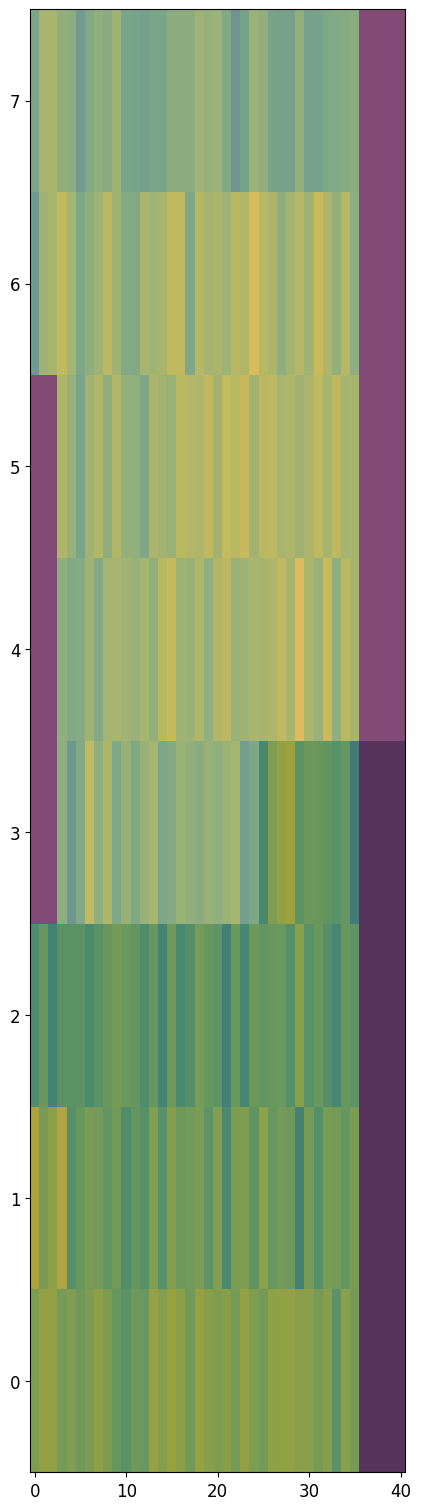


Working with slit/slice:  4
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[2017 2048]
 [1320 1328]]
Max value in slity array (ignoring NANs):  0.4992600265017523
percentage of F/O trace that was flagged: 96.6


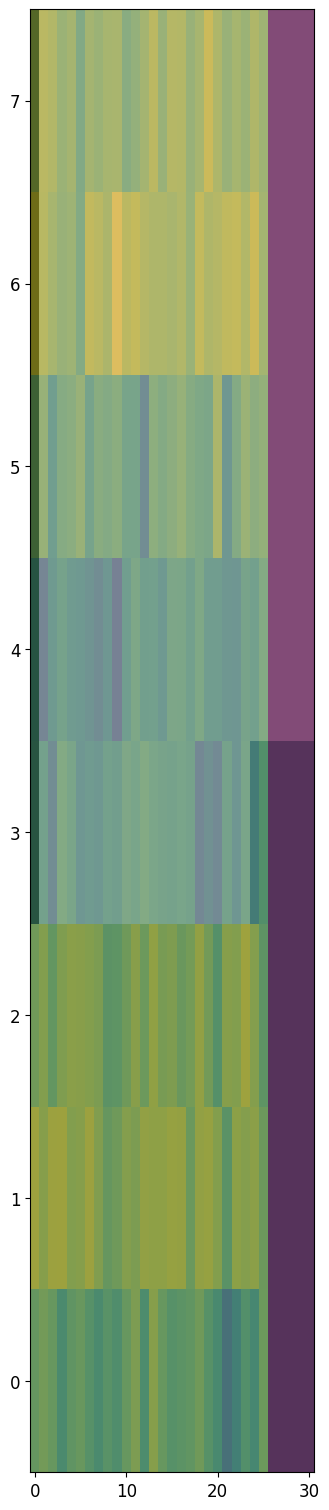


Working with slit/slice:  5
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[1873 2048]
 [1590 1600]]
Max value in slity array (ignoring NANs):  0.49970473402574966
percentage of F/O trace that was flagged: 100.0


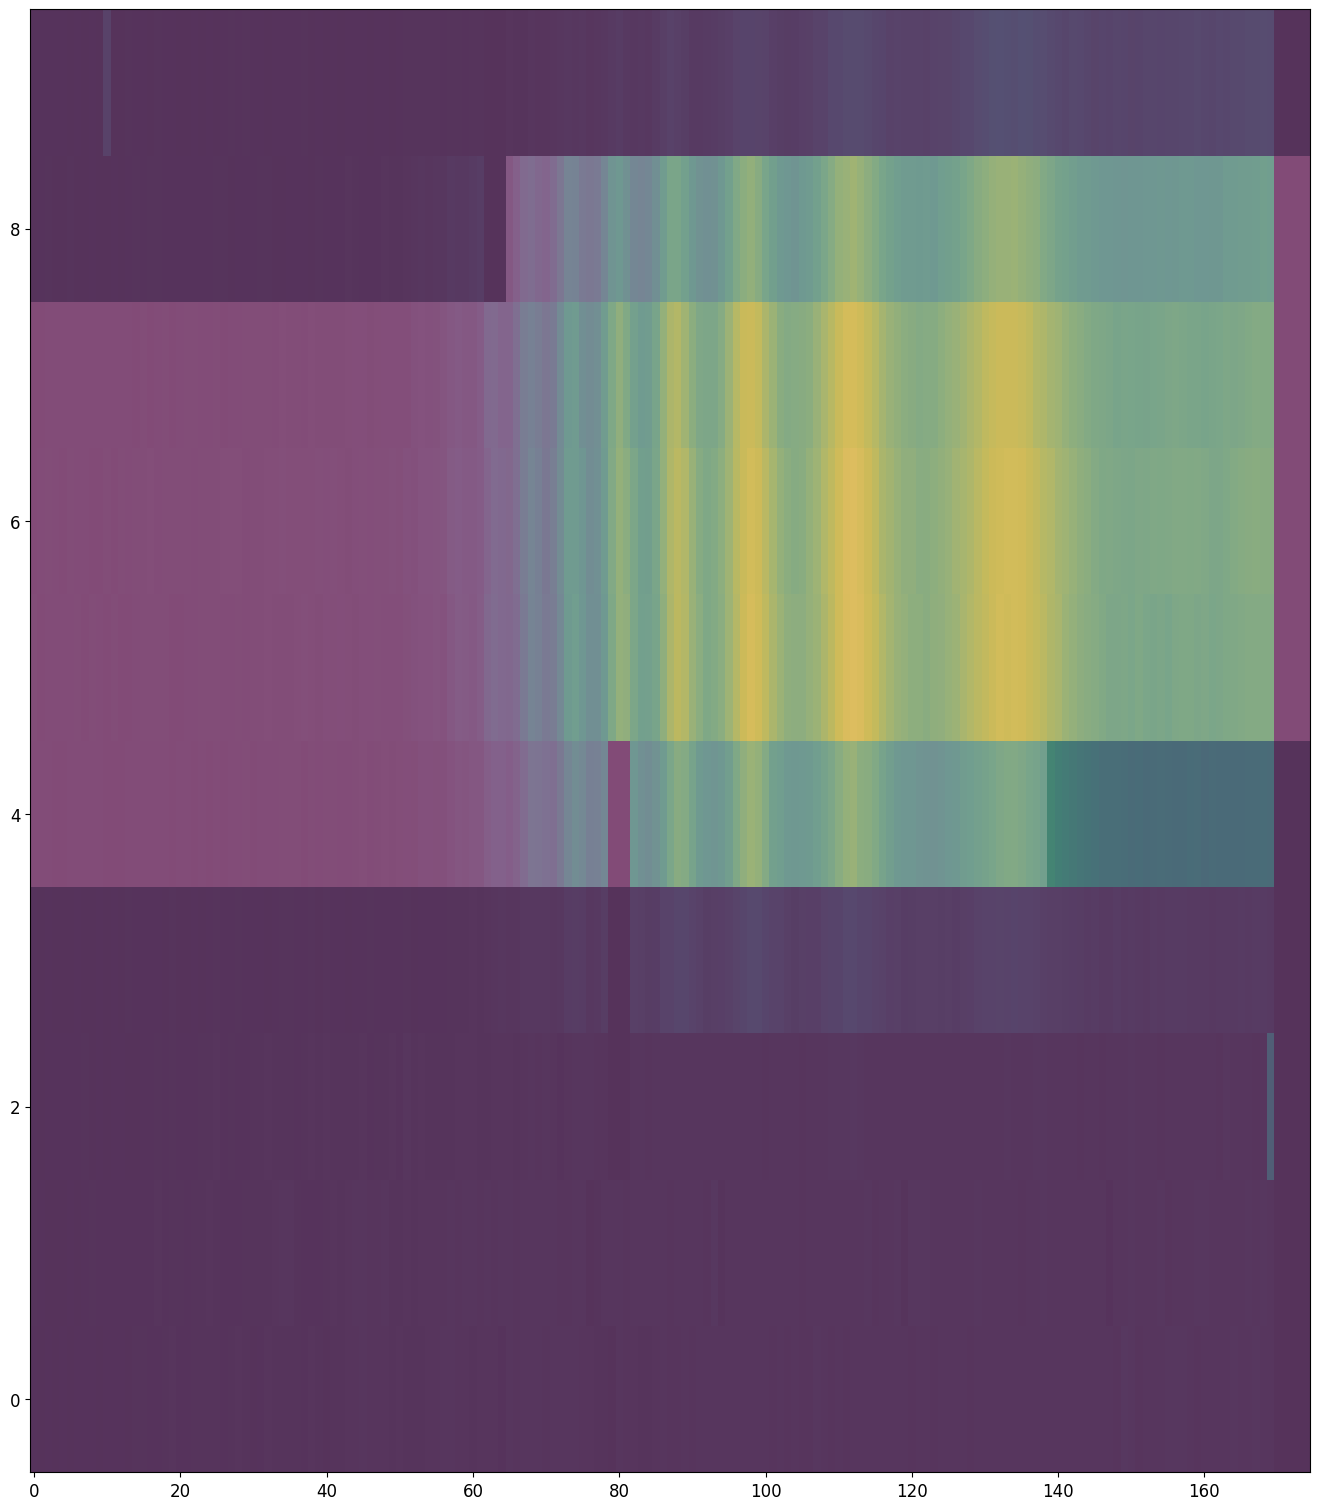


Working with slit/slice:  9
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[1511 1939]
 [1262 1270]]
Max value in slity array (ignoring NANs):  0.47541638939121267
percentage of F/O trace that was flagged: 100.0


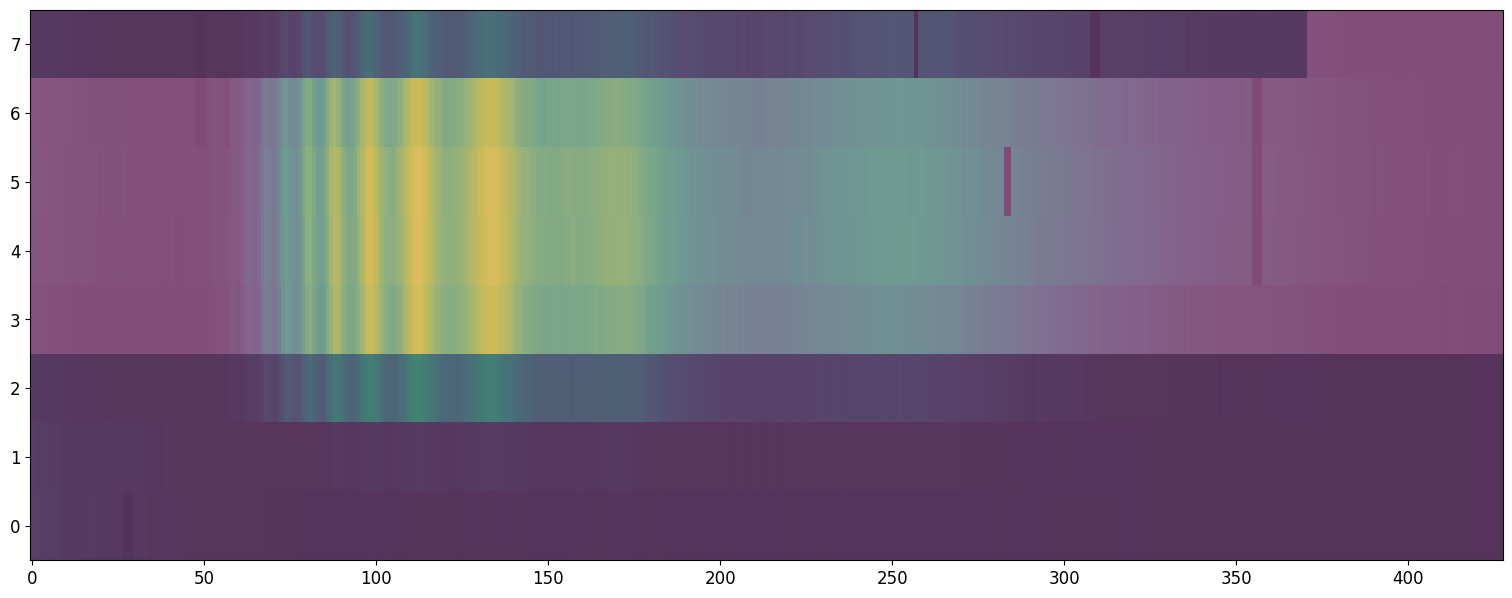


Working with slit/slice:  10
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[1515 1943]
 [1230 1240]]
Max value in slity array (ignoring NANs):  0.4999677623917731
percentage of F/O trace that was flagged: 100.0


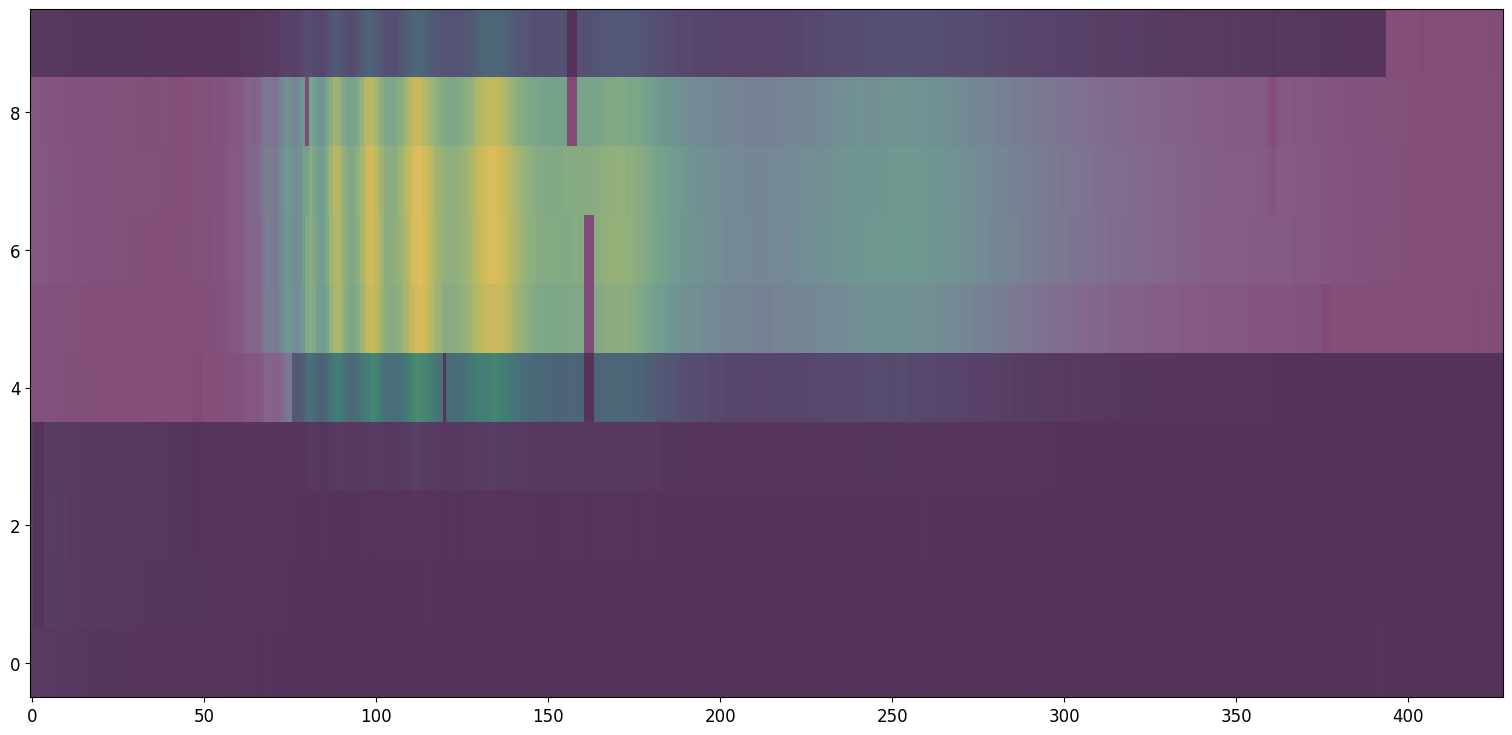


Working with slit/slice:  11
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1160 1594]
 [1828 1836]]
Max value in slity array (ignoring NANs):  0.4975789418957247
percentage of F/O trace that was flagged: 100.0


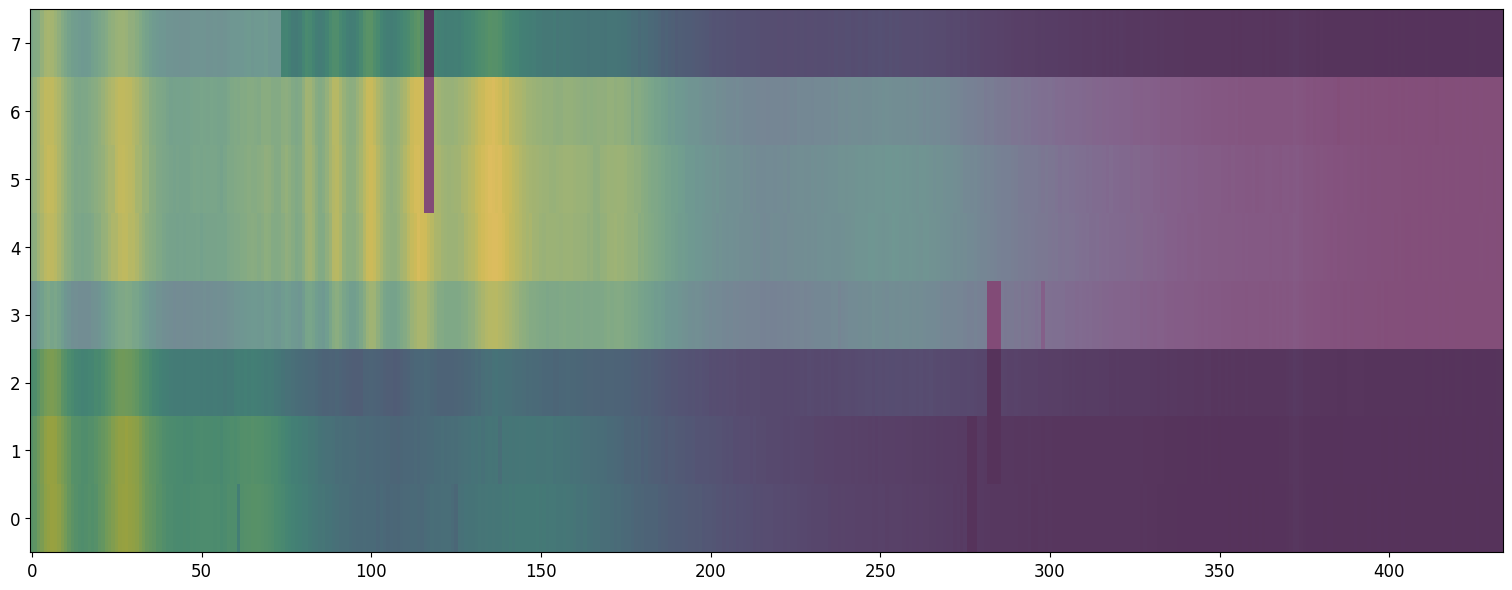


Working with slit/slice:  12
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[1213 1643]
 [1252 1260]]
Max value in slity array (ignoring NANs):  0.4911821622434934
percentage of F/O trace that was flagged: 100.0


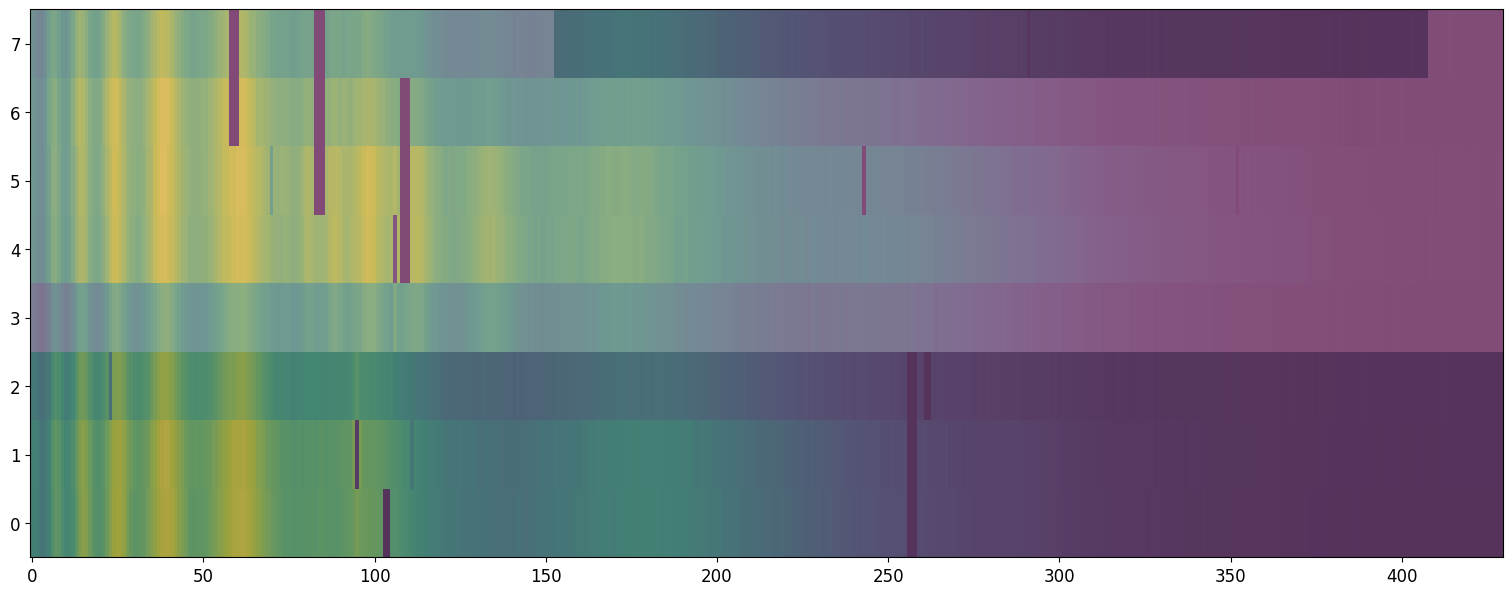


Working with slit/slice:  13
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 920 1356]
 [1692 1702]]
Max value in slity array (ignoring NANs):  0.4997273932113973
percentage of F/O trace that was flagged: 100.0


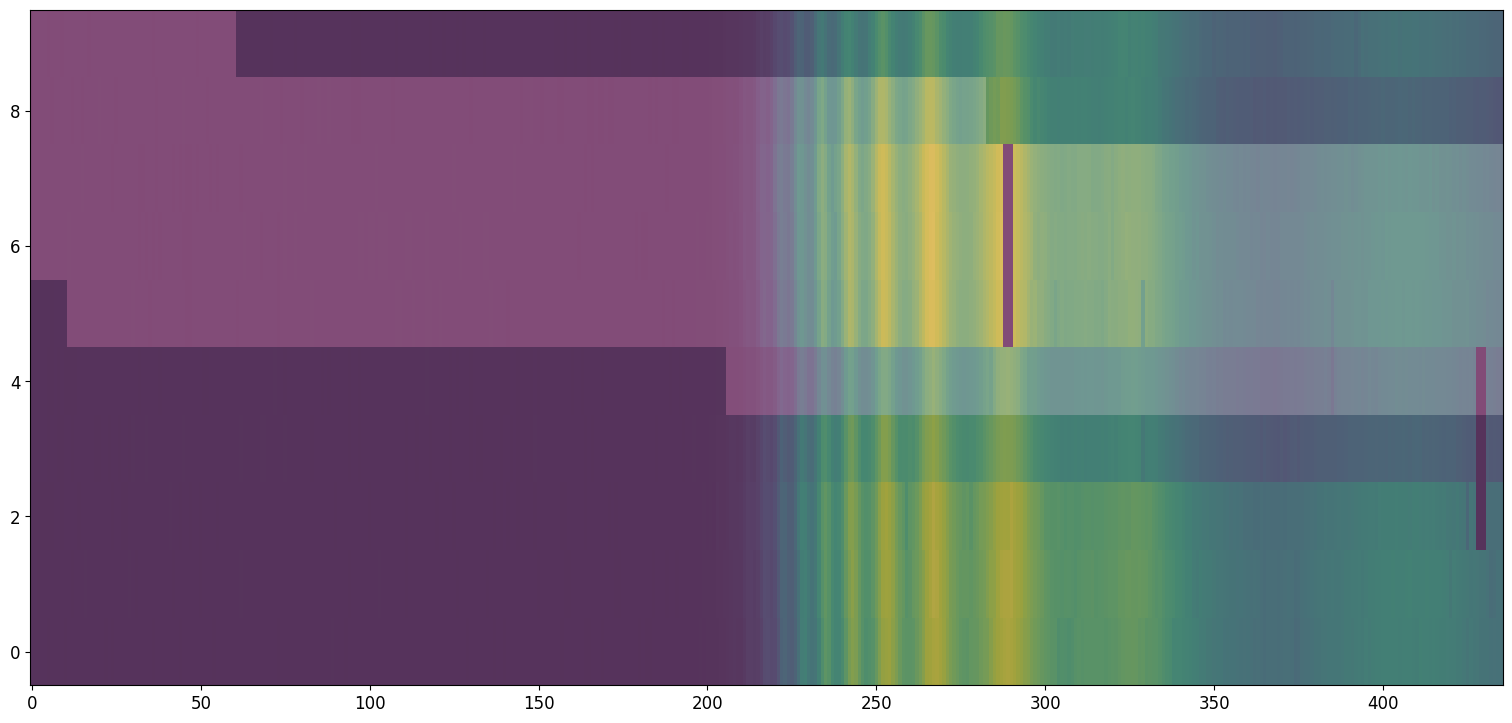


Working with slit/slice:  14
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 819 1255]
 [1632 1642]]
Max value in slity array (ignoring NANs):  0.4998008389664905
percentage of F/O trace that was flagged: 99.8


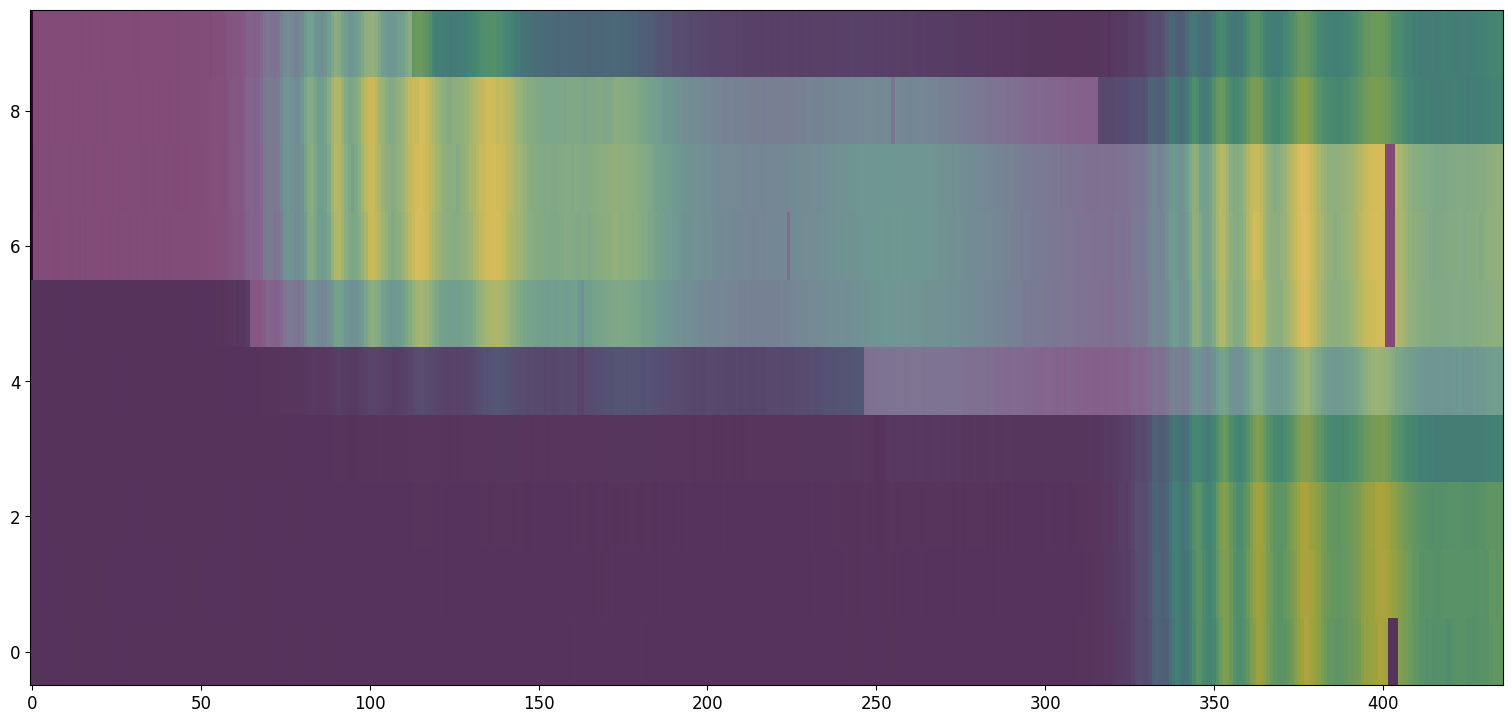


Working with slit/slice:  15
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 736 1172]
 [1376 1388]]
Max value in slity array (ignoring NANs):  0.49973439389336194
percentage of F/O trace that was flagged: 99.8


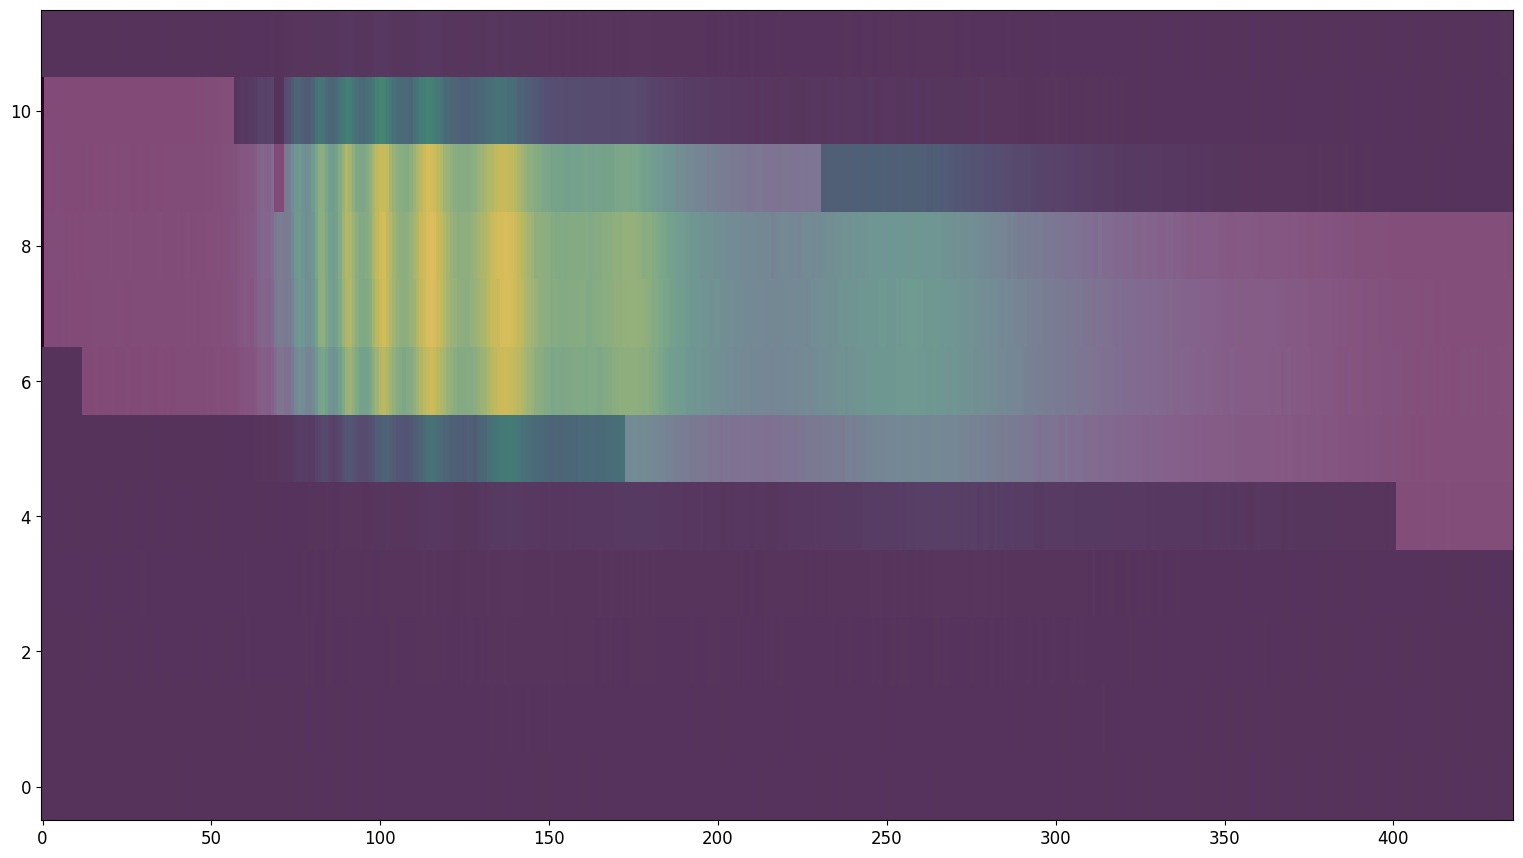


Working with slit/slice:  16
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 656 1096]
 [1862 1874]]
Max value in slity array (ignoring NANs):  0.49919217087642653
percentage of F/O trace that was flagged: 99.8


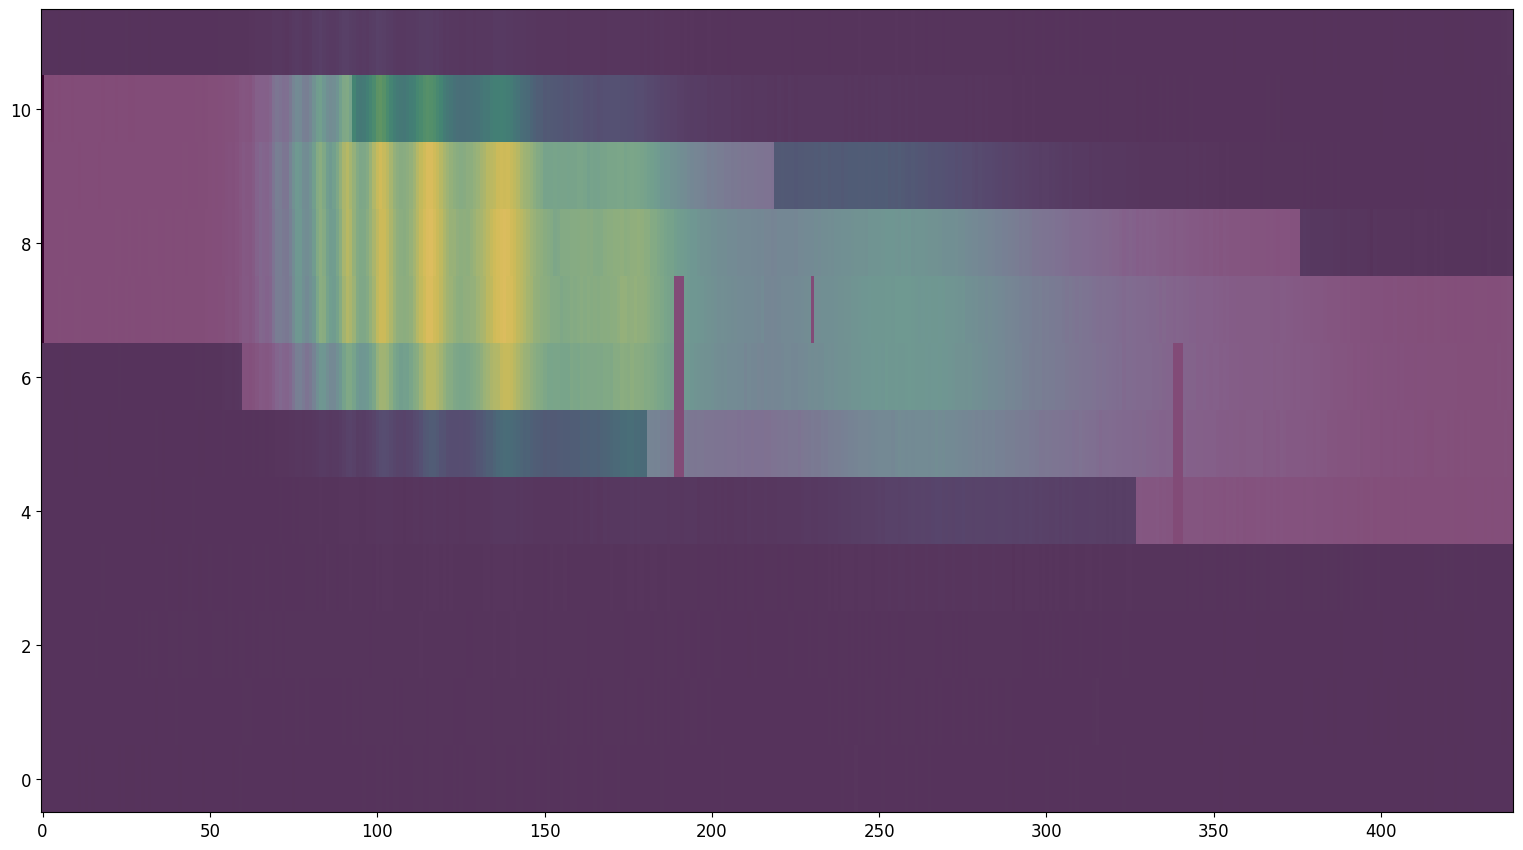


Working with slit/slice:  17
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 707 1144]
 [1518 1528]]
Max value in slity array (ignoring NANs):  0.49950881420114257
percentage of F/O trace that was flagged: 99.8


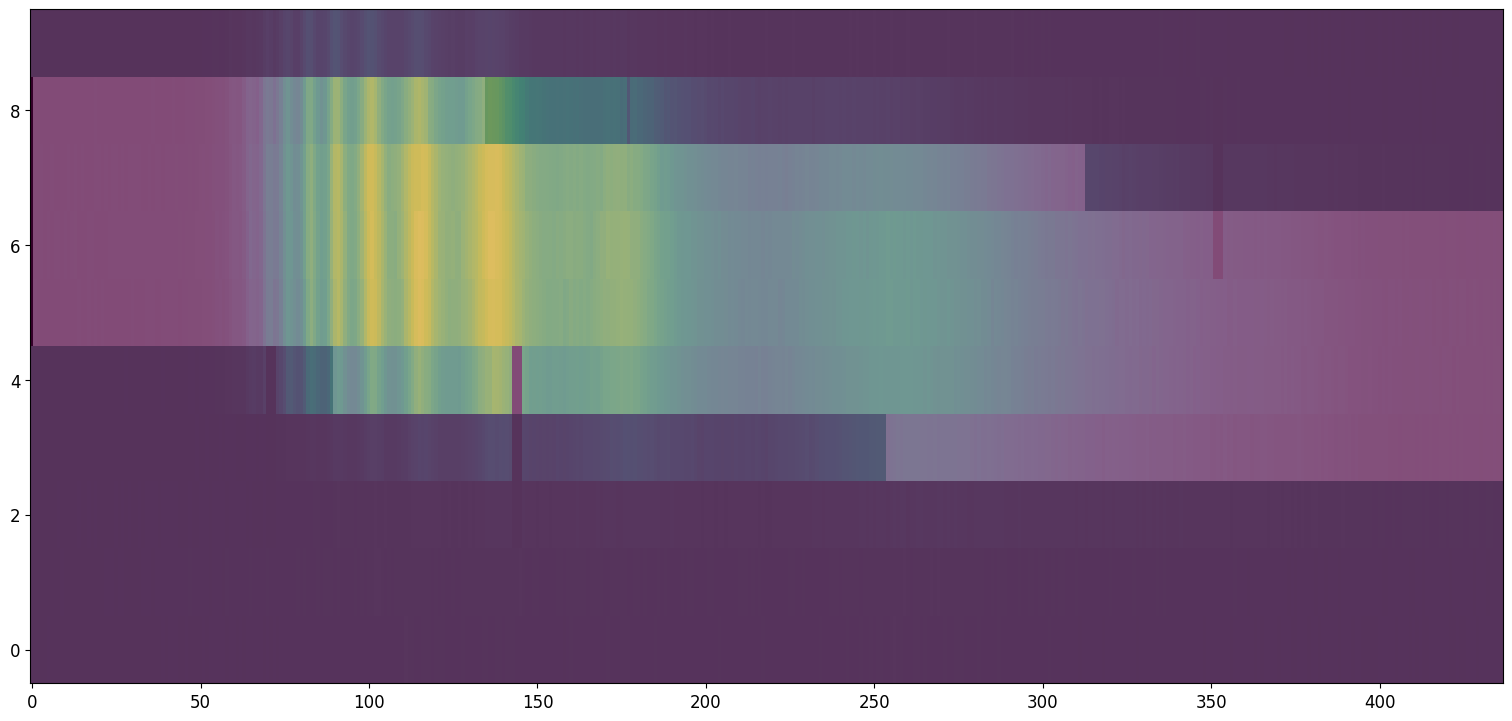


Working with slit/slice:  18
Slit min and max in y direction:  -0.5 0.5
bounding box rounded to next integer:  [[ 859 1287]
 [ 206  214]]
Max value in slity array (ignoring NANs):  0.4985413500738489
percentage of F/O trace that was flagged: 100.0


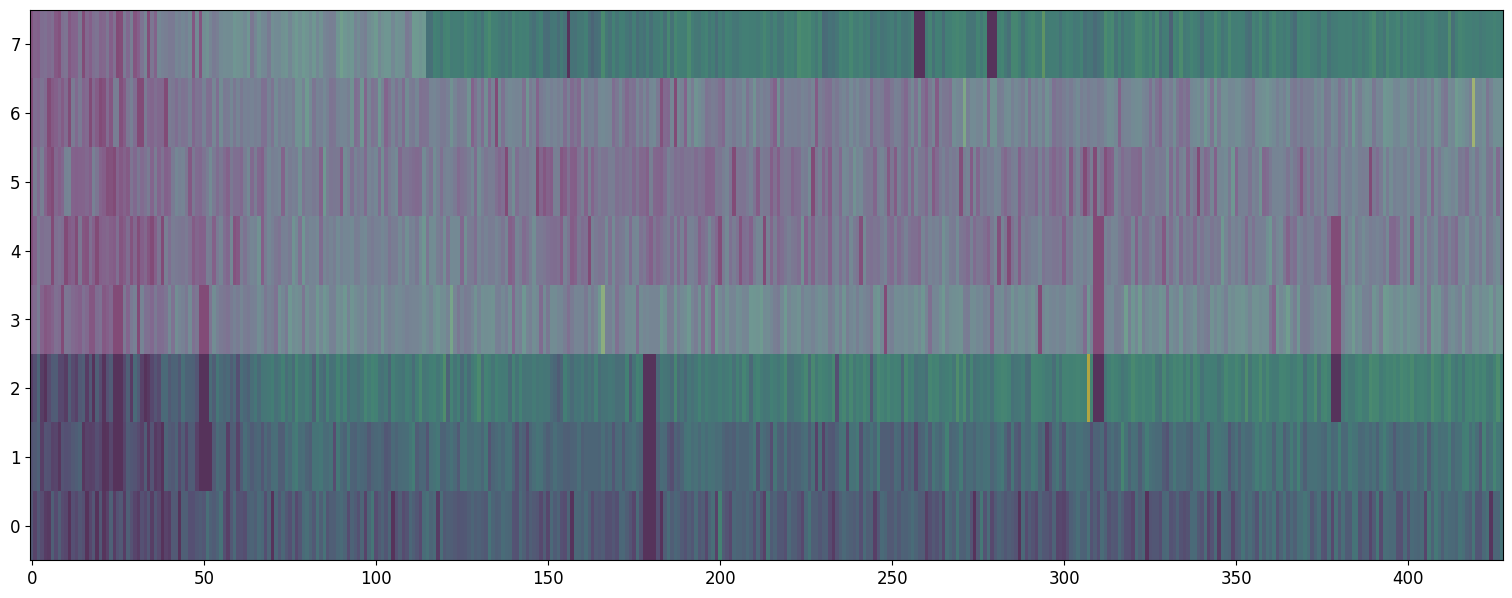


Working with slit/slice:  19
Slit min and max in y direction:  -0.5 0.5


bounding box rounded to next integer:  [[ 761 1193]
 [ 624  634]]
Max value in slity array (ignoring NANs):  0.4996526774597415
percentage of F/O trace that was flagged: 99.8


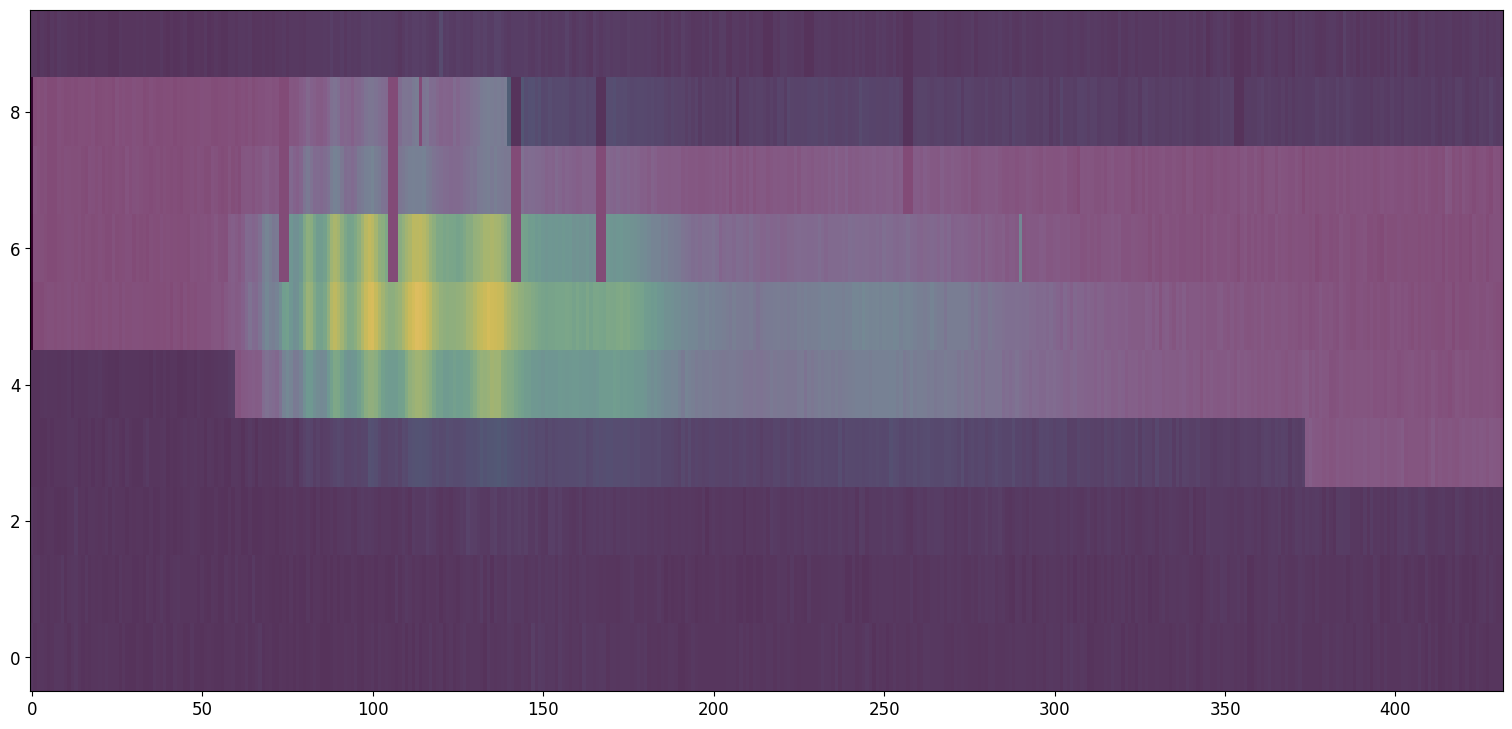


 * One or more traces show msa_flagging match <  99.5
   See results above per trace. 


 *** Final result for msa_flagging test will be reported as FAILED *** 

('* MSA flagging validation test took ', '15.37730622291565 seconds to finish.')
Did msa_flagging validation test pass?  False 


Testing files for detector:  nrs2


2022-12-03 23:47:08,618 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/mos_prism_nrs2_uncal.fits


2022-12-03 23:47:08,637 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-03 23:47:08,638 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-03 23:47:08,639 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-03 23:47:08,640 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-03 23:47:08,641 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-03 23:47:08,642 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-03 23:47:08,643 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-03 23:47:08,644 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-03 23:47:08,646 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-03 23:47:08,646 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-03 23:47:08,647 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-03 23:47:08,648 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-03 23:47:08,650 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-03 23:47:08,651 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-03 23:47:08,652 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-03 23:47:08,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-03 23:47:08,654 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-03 23:47:08,889 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/mos_prism_nrs2_uncal.fits',).


2022-12-03 23:47:08,899 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-12-03 23:47:09,084 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'mos_prism_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-03 23:47:09,360 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits'.


2022-12-03 23:47:09,393 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-12-03 23:47:09,396 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits'.


2022-12-03 23:47:09,410 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits'.


2022-12-03 23:47:09,420 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-03 23:47:09,420 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits'.


2022-12-03 23:47:09,423 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits'.


2022-12-03 23:47:09,425 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-12-03 23:47:09,425 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-12-03 23:47:09,426 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits'.


2022-12-03 23:47:09,429 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits'.


2022-12-03 23:47:09,436 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-03 23:47:09,437 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-03 23:47:09,437 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-03 23:47:09,820 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:09,821 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:47:09,941 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-12-03 23:47:09,942 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-03 23:47:09,945 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-03 23:47:10,077 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:10,078 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:47:10,101 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits


2022-12-03 23:47:10,407 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-03 23:47:10,540 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:10,541 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'n_pix_grow_sat': 1}


2022-12-03 23:47:10,563 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0021.fits


2022-12-03 23:47:12,711 - stpipe.Detector1Pipeline.saturation - INFO - Detected 40672 saturated pixels


2022-12-03 23:47:12,737 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-03 23:47:12,761 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-03 23:47:12,895 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:12,896 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:47:12,897 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-03 23:47:12,899 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-03 23:47:13,031 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:13,032 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:47:13,058 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0114.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-12-03 23:47:18,971 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-12-03 23:47:19,114 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:19,115 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-03 23:47:19,145 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0020.fits


2022-12-03 23:47:23,175 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-12-03 23:47:38,977 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-03 23:47:39,366 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:39,368 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:47:39,401 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0021.fits


2022-12-03 23:47:44,772 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-03 23:47:45,098 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:47:45,100 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'dark_output': None}


2022-12-03 23:47:45,187 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0087.fits


2022-12-03 23:48:25,846 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=4, nframes=1, groupgap=0


2022-12-03 23:48:25,847 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-12-03 23:48:26,419 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-03 23:48:26,743 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:48:26,745 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-03 23:48:26,787 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-03 23:48:26,850 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-12-03 23:48:28,006 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-12-03 23:48:28,321 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-03 23:48:28,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-12-03 23:48:29,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-12-03 23:48:30,219 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1.89669 sec


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:302: RuntimeWarning: invalid value encountered in divide
  data /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:303: RuntimeWarning: invalid value encountered in divide
  err /= gain_2d
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/jump.py:304: RuntimeWarning: invalid value encountered in divide
  readnoise_2d /= gain_2d
2022-12-03 23:48:30,316 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 3.528770


2022-12-03 23:48:30,322 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-03 23:48:30,618 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:48:30,620 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-03 23:48:30,717 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-12-03 23:48:30,718 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-12-03 23:48:30,852 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-03 23:48:30,853 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-12-03 23:48:44,904 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 4


2022-12-03 23:48:44,905 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-12-03 23:48:45,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-03 23:48:45,399 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:48:45,401 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:48:45,743 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 23:48:45,744 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 23:48:45,748 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 23:48:45,888 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:48:45,890 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx'}


2022-12-03 23:48:45,964 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 23:48:45,965 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 23:48:45,970 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 23:48:45,970 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-03 23:48:45,971 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 23:48:45,971 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-03 23:48:45,981 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 23:48:46,107 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs2_uncal.fits>,).


2022-12-03 23:48:46,109 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


Using MSA shutter config:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9pkps3xx/V0030006000104_msa.fits


2022-12-03 23:48:46,264 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-12-03 23:48:46,310 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg


2022-12-03 23:48:46,310 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg


2022-12-03 23:48:46,311 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg


2022-12-03 23:48:46,312 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-12-03 23:48:46,607 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:48:46,690 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-12-03 23:48:46,692 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: []


2022-12-03 23:48:46,693 - stpipe.AssignWcsStep - CRITICAL - No open slits fall on detector NRS2.


An error occured with AssignWcs. Likely: No open slits fall on detector nrs2
Skipping test for this file. 

Did msa_flagging validation test pass?  skipped 




In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
msa_flagging_threshold = 99.5

# other NPTT variables
stellarity = None
operability_ref = None
source_type = None
save_figs = False
show_figs = True
debug = False
verbose = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
                
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            rate_object.meta.instrument.msa_metadata_file = msa_shutter_config
            print('Using MSA shutter config: ', rate_object.meta.instrument.msa_metadata_file)

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print("An error occured with AssignWcs. Likely: No open slits fall on detector", det)
            print("Skipping test for this file. \n")
            skip_file = True
       
        if not skip_file:
            msa_flagging_object = MSAFlagOpenStep.call(pipe_object)

            # Run the validation test
            %matplotlib inline

            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.msa_flagging_testing.run_msa_flagging_testing(
                                                                        msa_flagging_object, 
                                                                        msa_flagging_threshold = msa_flagging_threshold,
                                                                        rate_obj = rate_object,
                                                                        stellarity = stellarity, 
                                                                        operability_ref = operability_ref, 
                                                                        save_figs = save_figs, 
                                                                        show_figs = show_figs, 
                                                                        source_type = source_type, 
                                                                        debug = debug)

        else:
            result = 'skipped'


        # Did the test pass
        print("Did msa_flagging validation test pass? ", result, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                if verbose:
                    print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                if verbose:
                    print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed: Do the NIRSpec implementation and the pipeline's agree within <= 99.5%?

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<40} {:<8}'.format(key, val))


These are the final results of the tests: 
mos_prism_nrs1_uncal.fits                FAILED  
mos_prism_nrs2_uncal.fits                skipped 


# <a id="about_ID"></a>
## About this Notebook
**Authors:** 
- Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
- Emily Wislowski, Science Support Analyst I, NIRSpec

<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 